# Sensitivity analysis

## Biblioteka SALib i funkcja Ishigami

In [5]:
# import libraries
%load_ext autotime
from SALib.plotting.bar import plot as barplot
from SALib.sample import saltelli, fast_sampler, morris as morris_sample
from SALib.analyze import sobol, fast, morris
from SALib.test_functions import Ishigami
import numpy as np
import math

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.26 ms


In [6]:
# Define the model inputs
problem = {
    'num_vars': 3,
    'names': ['x1', 'x2', 'x3'],
    'bounds': [[-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359]]
}

time: 874 µs


In [7]:
# Generate samples for SOBOL
param_values_sobol = saltelli.sample(problem, 1000)

time: 57.4 ms


In [8]:
# Evaluate Ishigami model
Y_Ishigami_sobol = Ishigami.evaluate(param_values_sobol)

time: 16.5 ms


In [9]:
# SOBOL METHOD
Si_sobol = sobol.analyze(problem, Y_Ishigami_sobol, print_to_console=True)

Parameter S1 S1_conf ST ST_conf
x1 0.307975 0.057618 0.560137 0.081903
x2 0.447767 0.050202 0.438722 0.035571
x3 -0.004255 0.051709 0.242845 0.026379

Parameter_1 Parameter_2 S2 S2_conf
x1 x2 0.012205 0.081733
x1 x3 0.251526 0.102452
x2 x3 -0.009954 0.066096
time: 41.8 ms


__Zadanie 1:__ Użyj innych algorytmów do tworzenia próbek i analizowania modelu dostępnych w SALib, przeanalizuj otrzymane wyniki a także czas wykonania algorytmów analizujących. - https://salib.readthedocs.io/en/latest/api.html. Wskazówka: dla metody fast należy użyć samplera fast_sampler, a dla metody morris samplera morris_sample.

## Użycie własnego modelu w bibliotece SALib

Poniżej został pokazany przykład badania wrażliwości modelu Net Present Value (https://www.wallstreetmojo.com/net-present-value-npv-formula). Badamy zrażliwość modelu na początkowy koszt inwestycji i na wpływy środków w czasie (zakładamy stały dopływ środków). 

In [10]:
def evaluate(values):
    Y = np.zeros([values.shape[0]])
    t = 5
    R = 0.1
    
    for i, X in enumerate(values):
        sum = 0
        for i in range(t):
            sum += X[0]/((1 + R) ** i - X[1])
        Y[i] = sum
    return Y

# Define the model inputs
problem = {
    'num_vars': 2,
    'names': ['x1', 'x2',],
    'bounds': [[10, 100],
               [10, 1000]]
}
# Generate samples for SOBOL
param_values_sobol = saltelli.sample(problem, 1000)
# Evaluate Ishigami model
Y_Ishigami_sobol = evaluate(param_values_sobol)
# SOBOL METHOD
Si_sobol = sobol.analyze(problem, Y_Ishigami_sobol, print_to_console=True)

Parameter S1 S1_conf ST ST_conf
x1 0.000000 0.000000 0.000000 0.000000
x2 0.000000 0.000000 0.000000 0.000000

Parameter_1 Parameter_2 S2 S2_conf
x1 x2 0.000000 0.000000
time: 81.8 ms


__Zadanie 2:__ Zaimplementować własny model fizyczny/matematyczny/biznesowy i zbadać jego wrażliwość. Np: Dividend discount model (https://en.wikipedia.org/wiki/Dividend_discount_model)

## Predator-prey model

In [11]:
from scipy import integrate
import pylab as p

time: 160 ms


In [12]:
simulationSteps = 100
startSimulationTime = 0
endSimulationTime = 15
sampleNum = 100

time: 675 µs


In [13]:
class PredatorPreyModel:
    simulationsResults = []
    initialPredatorPopulation = 10
    initialPreyPopulation = 5
    alfa = 1.
    beta = 0.2
    gamma = 1.5
    delta = 0.75
    
    def dX_dt(self, X, t):
          return np.array([ self.alfa*X[0] - self.beta*X[0]*X[1] ,
                         -self.gamma*X[1] + self.delta*self.beta*X[0]*X[1] ])

    def setupModel(self, values):
        for i, X in enumerate(values):
            # prey and pred populations at beginning
            predatorPreyPopulations = np.array([self.initialPredatorPopulation, self.initialPreyPopulation])
            t = np.linspace(startSimulationTime, endSimulationTime,  simulationSteps) 
            self.alfa = X[0] # !!! self.alfa, self.beta, self.gamma, self.delta
            self.beta = X[1]

            # calculate predator-prey 
            PPPolulationsAtStep, infodict = integrate.odeint(self.dX_dt, predatorPreyPopulations, t, full_output=True)
            self.simulationsResults.append(PPPolulationsAtStep)

    def getArrayOfModelValues(self, step):
        Y = np.zeros([len(self.simulationsResults)])
        for i in range(len(self.simulationsResults)):
            Y[i] = self.simulationsResults[i][step][0] # [0] for predators, [1] for preys
        return Y


time: 3.24 ms


In [14]:
class ModifiedPredatorPreyModel:
    simulationsResults = []
    initialPredatorPopulation = 10
    initialPreyPopulation = 5
    alfa = 1.
    beta = 0.2
    gamma = 1.5
    delta = 0.75
    K = 10
    
    def dX_dt(self, X, t):
          return np.array([ self.alfa*X[0]*(1-X[0]/self.K) - self.beta*X[0]*X[1] ,
                         -self.gamma*X[1] + self.delta*self.beta*X[0]*X[1] ])

    def setupModel(self, values):
        for i, X in enumerate(values):
            # prey and pred populations at beginning
            predatorPreyPopulations = np.array([self.initialPredatorPopulation, self.initialPreyPopulation])
            t = np.linspace(startSimulationTime, endSimulationTime,  simulationSteps) 
            self.alfa = X[0] # !!! self.alfa, self.beta, self.gamma, self.delta
            self.beta = X[1] # !!!

            # calculate predator-prey 
            PPPolulationsAtStep, infodict = integrate.odeint(self.dX_dt, predatorPreyPopulations, t, full_output=True)
            self.simulationsResults.append(PPPolulationsAtStep)

    def getArrayOfModelValues(self, step):
        Y = np.zeros([len(self.simulationsResults)])
        for i in range(len(self.simulationsResults)):
            Y[i] = self.simulationsResults[i][step][0] # [0] for predators, [1] for preys !!!
        return Y

time: 3.57 ms


In [15]:
# Define the model inputs
problem = {
    'num_vars': 2,
    'names': ['alfa', 'beta'],
    'bounds': [[0.75, 1.25],
               [0.15, 0.25]]
}

time: 905 µs


In [16]:
# Generate samples
param_values = saltelli.sample(problem, sampleNum)

time: 20.8 ms


In [17]:
# Calculate sensivitness for evry simulation step
sensitivity = []
alfaAndBetaSensitivity = []
alfaSensitivity = []
betaSensitivity = []

model = PredatorPreyModel() # ModifiedPredatorPreyModel() !!!
model.setupModel(param_values)

for i in range(simulationSteps):
    # get array of model values at time step 'i'
    Y = model.getArrayOfModelValues(i)
    # analyze these values using sobol method
    Si = sobol.analyze(problem, Y, print_to_console=False)

    alfaSensitivity.append(Si['S1'][0])
    betaSensitivity.append(Si['S1'][1])
    alfaAndBetaSensitivity.append(Si['S2'][0,1])

/usr/local/lib/python3.7/site-packages/SALib/analyze/sobol.py:93: RuntimeWarning: invalid value encountered in true_divide
  Y = (Y - Y.mean()) / Y.std()


time: 916 ms


Text(0.5, 1.0, 'Sensitivness of alfa & beta in time for predator')

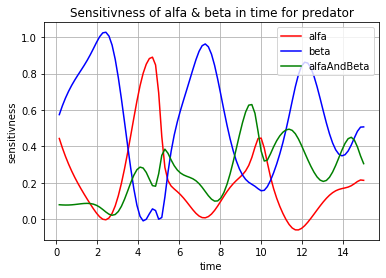

time: 243 ms


In [18]:
# plot results
t = np.linspace(startSimulationTime, endSimulationTime,  simulationSteps)
f1 = p.figure()
p.plot(t, alfaSensitivity, 'r-', label='alfa')
p.plot(t, betaSensitivity, 'b-', label='beta')
p.plot(t, alfaAndBetaSensitivity, 'g-', label='alfaAndBeta')
p.grid()
p.legend(loc='best')
p.xlabel('time')
p.ylabel('sensitivness')
p.title('Sensitivness of alfa & beta in time for predator')

__Zadanie 3:__ Zbadać wrażliwość zmiennych alfa, beta gamma, delta modelu predator-prey lub zmodyfikowanego model predator-prey. Należy zbadać to dla predator jak i dla prey.